In [4]:
import os
import numpy as np
from PIL import Image
import pyiqa
import torch
import random
import matplotlib.pyplot as plt

# 模型配置字典 -> {模型名称: 模型文件夹路径}
MODEL_CONFIGS = {
    "SADCNN": "/home/shenss/python/dataset/Celebrity Face Image Dataset/show_ori/SAD_FS",
    "MSPRL": "/home/shenss/python/dataset/Celebrity Face Image Dataset/show_ori/MSPRL_FS",
    "UNet": "/home/shenss/python/dataset/Celebrity Face Image Dataset/show_ori/IHUnet_FS",
    # "CycleGAN": "/home/shenss/python/dataset/Celebrity Face Image Dataset/show_ori/CycleGAN_FS",
    # "UnetGAN": "/home/shenss/python/dataset/Celebrity Face Image Dataset/show_ori/UnetGAN_FS",
    "DiffSo_FS": "/home/shenss/python/DiffSo/results/DiffSo_CFID_80K_TS5_FS",
    "DiffSo_Ost": "/home/shenss/python/DiffSo/results/DiffSo_CFID_80K_TS5_Ost",
    "DiffSo_JJN": "/home/shenss/python/DiffSo/results/DiffSo_CFID_80K_TS5_JJN",
    "DiffSoGS3_JJN": "/home/shenss/python/DiffSo/results/DiffSoGS3_CFID_80K_TS5_JJN",
    "DiffSo_Stucki": "/home/shenss/python/DiffSo/results/DiffSo_CFID_80K_TS5_Stucki",
    #"DiffSo_gs": "/home/shenss/python/DiffSo/results/DiffSo_CFID_80K_TS5_get_Sobel",
    # "DiffSo_ep10": "/home/sss/python/DiffSo/results/DiffSo_FS_Gaussian_ts5_10K",
    # "DiffSo_ep20": "/home/sss/python/DiffSo/results/DiffSo_FS_Gaussian_ts5_20K",
    # "DiffSo_ep30": "/home/sss/python/DiffSo/results/DiffSo_FS_Gaussian_ts5_30K",
}

class ImageEvaluator:
    def __init__(self, gt_path, model_paths):
        self.gt_path = gt_path
        self.model_paths = model_paths
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 初始化评估指标
        self.metrics = {
            "PSNR": pyiqa.create_metric("psnr", device=self.device),
            "SSIM": pyiqa.create_metric("ssim", device=self.device),
            "VIF": pyiqa.create_metric("vif", device=self.device),
            "DISTS": pyiqa.create_metric("dists", device=self.device),
            "LPIPS": pyiqa.create_metric("lpips", device=self.device),
            "FID": pyiqa.create_metric("fid", device=self.device),
        }

        # 初始化结果存储
        self.results = {
            model: {metric: [] for metric in self.metrics.keys()}
            for model in self.model_paths.keys()
        }

    def load_and_preprocess(self, img_path):
        img = (
            np.array(Image.open(img_path).resize((256, 256))).astype(np.float32) / 255.0
        )
        return torch.from_numpy(img).to(self.device).unsqueeze(0).permute(0, 3, 1, 2)

    def visualize_samples(self, num_samples=5):
        """展示随机采样的图像比较"""
        plt.rcParams["font.family"] = "Times New Roman"

        # 随机采样图像
        image_names = os.listdir(self.gt_path)
        random_images = random.sample(image_names, num_samples)

        # 创建子图矩阵
        num_models = len(self.model_paths) + 2  # +2 for GT and input
        fig, axes = plt.subplots(
            num_samples, num_models, figsize=(2.5 * num_models, 3 * num_samples)
        )

        for i, img_name in enumerate(random_images):
            # 加载ground truth和输入图像
            img_gt = Image.open(os.path.join(self.gt_path, img_name)).resize((256, 256))
            img_input = Image.open(
                os.path.join(self.gt_path.replace("/gt_256", "/FS_256"), img_name)
            ).resize((256, 256))

            # 显示GT和输入图像
            axes[i, 0].imshow(img_gt)
            axes[i, 0].set_title("Ground Truth")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(img_input)
            axes[i, 1].set_title("Halftone")
            axes[i, 1].axis("off")

            # 显示每个模型的结果
            for j, (model_name, model_path) in enumerate(self.model_paths.items()):
                img = Image.open(os.path.join(model_path, img_name)).resize((256, 256))
                axes[i, j + 2].imshow(img)
                axes[i, j + 2].set_title(model_name)
                axes[i, j + 2].axis("off")

        plt.tight_layout()
        plt.show()

    def evaluate_images(self):
        image_names = os.listdir(self.gt_path)

        for img_name in image_names:
            img_gt_tensor = self.load_and_preprocess(
                os.path.join(self.gt_path, img_name)
            )

            for model_name, model_path in self.model_paths.items():
                img_model_tensor = self.load_and_preprocess(
                    os.path.join(model_path, img_name)
                )

                # 计算所有指标
                for metric_name, metric_fn in self.metrics.items():
                    if metric_name != "FID":
                        result = metric_fn(img_gt_tensor, img_model_tensor).item()
                        self.results[model_name][metric_name].append(result)

        # 计算FID (只需计算一次)
        for model_name, model_path in self.model_paths.items():
            self.results[model_name]["FID"] = self.metrics["FID"](
                self.gt_path, model_path
            )

    def get_averages(self):
        averages = {}
        for model_name in self.model_paths.keys():
            averages[model_name] = {}
            for metric_name in self.metrics.keys():
                if metric_name != "FID":
                    averages[model_name][metric_name] = np.mean(
                        self.results[model_name][metric_name]
                    )
                else:
                    averages[model_name][metric_name] = self.results[model_name][
                        metric_name
                    ]
        return averages

    def visualize_metrics(self):
        """可视化所有指标的评估结果"""
        plt.rcParams["font.family"] = "Times New Roman"

        metrics = [
            "PSNR (↑)",
            "SSIM (↑)",
            "VIF (↑)",
            "DISTS (↓)",
            "LPIPS (↓)",
            "FID (↓)",
        ]
        models = list(self.model_paths.keys())

        # 获取平均值并整理数据
        averages = self.get_averages()
        values = {model: [] for model in models}
        for model in models:
            values[model] = [
                averages[model]["PSNR"],
                averages[model]["SSIM"],
                averages[model]["VIF"],
                averages[model]["DISTS"],
                averages[model]["LPIPS"],
                averages[model]["FID"],
            ]

        # 创建子图，预留更多顶部空间
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.subplots_adjust(top=0.95, bottom=0.15)  # 调整上下边距
        axes = axes.flatten()

        width = 0.15
        bars = []

        for idx, metric in enumerate(metrics):
            ax = axes[idx]
            x = np.arange(1)

            ax.set_ylim(0, max([values[model][idx] for model in models]) * 1.2)

            for i, model in enumerate(models):
                pos = x + (i - len(models) / 2 + 0.5) * width
                rect = ax.bar(pos, values[model][idx], width)
                if idx == 0:
                    bars.append(rect)

                # 添加数值标注
                height = values[model][idx]
                ax.text(pos, height, f"{height:.3f}", ha="center", va="bottom")

            # 将标题移至底部
            ax.set_xlabel(metric, labelpad=10)
            ax.set_title("")  # 清除顶部标题
            ax.set_xticks([])

        # 删除多余的子图
        for idx in range(len(metrics), len(axes)):
            fig.delaxes(axes[idx])

        # 在最上方添加图例
        fig.legend(
            bars,
            models,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.0),
            ncol=len(models),
            borderaxespad=0,
        )

        plt.tight_layout()
        # 调整布局以适应顶部图例
        plt.subplots_adjust(top=0.95)
        plt.show()

In [5]:
# 设置 Ground Truth 图像文件夹路径
gt_path = "/home/shenss/python/dataset/Celebrity Face Image Dataset/test/gt_256"
    
# 计算 Full-reference IQA 指标
evaluator = ImageEvaluator(gt_path, MODEL_CONFIGS)

Loading pretrained model DISTS from /home/shenss/.cache/torch/hub/pyiqa/DISTS_weights-f5e65c96.pth
Loading pretrained model LPIPS from /home/shenss/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth
Loading pretrained model Inception3 from /home/shenss/.cache/torch/hub/pyiqa/pt_inception-2015-12-05-6726825d.pth


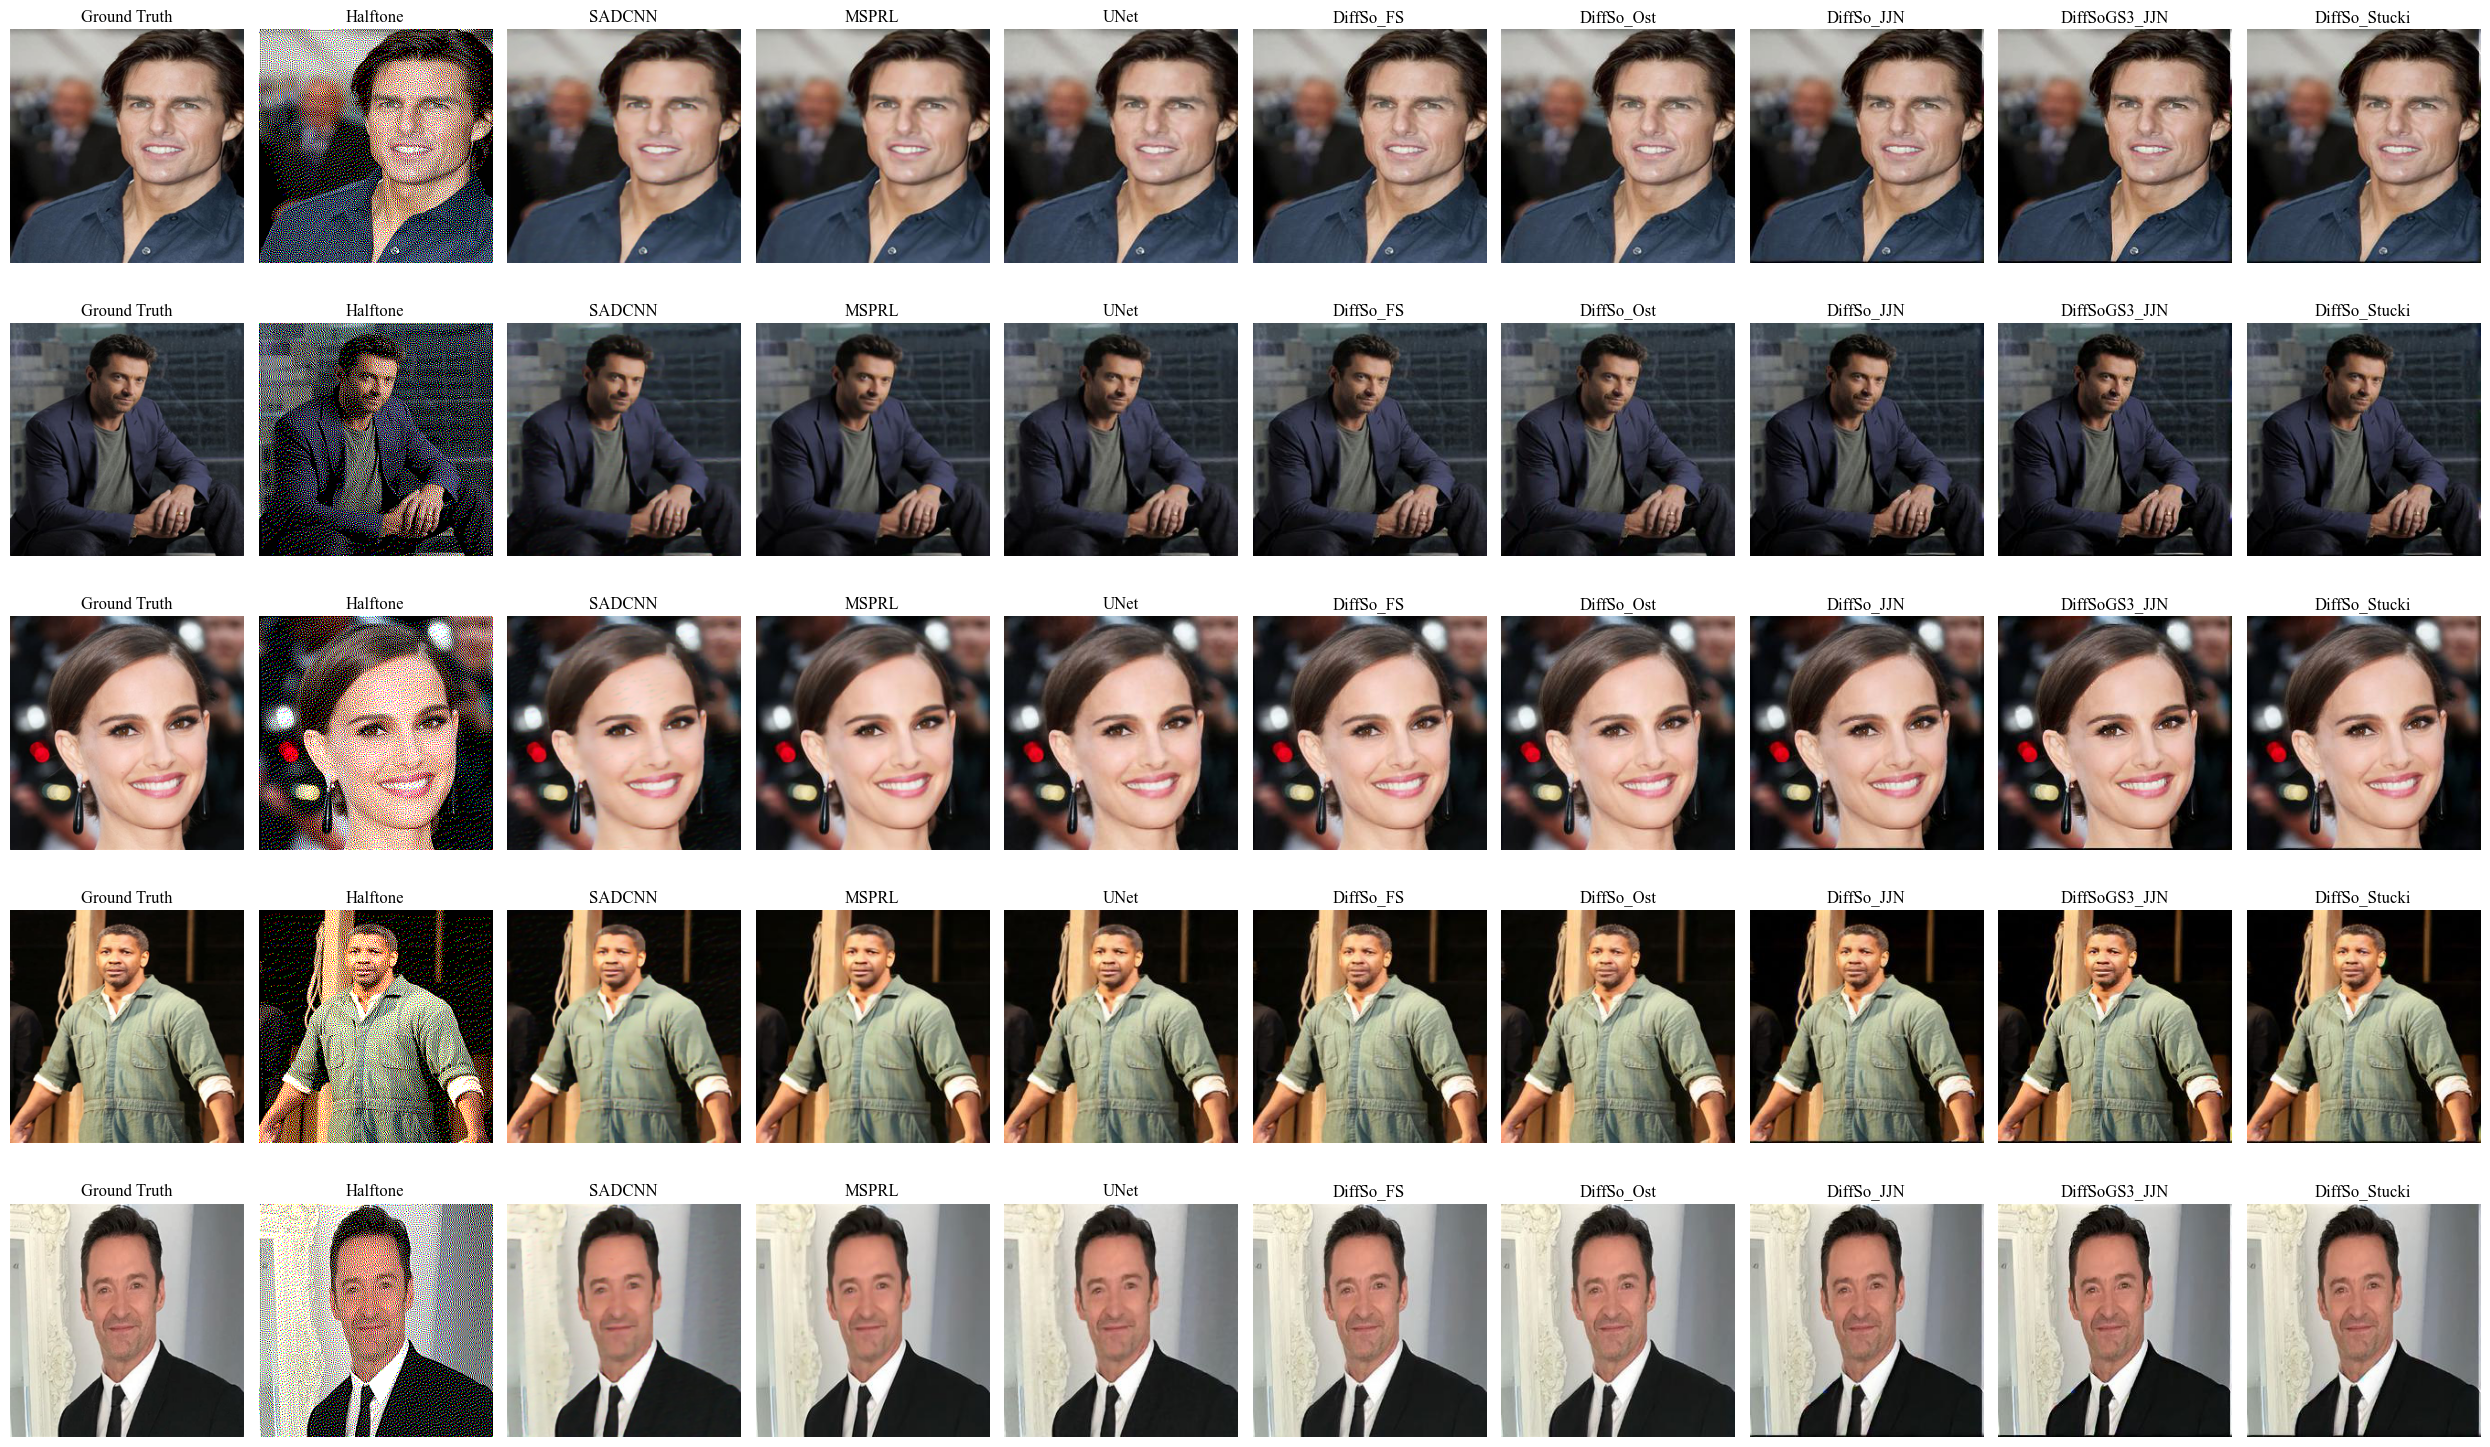

In [6]:
evaluator.visualize_samples(5)

In [7]:
evaluator.evaluate_images()

compute FID between two folders
Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/test/gt_256


FID gt_256: 100%|██████████| 22/22 [00:00<00:00, 41.19it/s]


Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/show_ori/SAD_FS


FID SAD_FS: 100%|██████████| 22/22 [00:01<00:00, 17.85it/s]


compute FID between two folders
Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/test/gt_256


FID gt_256: 100%|██████████| 22/22 [00:00<00:00, 54.54it/s]


Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/show_ori/MSPRL_FS


FID MSPRL_FS: 100%|██████████| 22/22 [00:00<00:00, 57.60it/s]


compute FID between two folders
Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/test/gt_256


FID gt_256: 100%|██████████| 22/22 [00:00<00:00, 51.76it/s]


Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/show_ori/IHUnet_FS


FID IHUnet_FS: 100%|██████████| 22/22 [00:00<00:00, 53.62it/s]


compute FID between two folders
Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/test/gt_256


FID gt_256: 100%|██████████| 22/22 [00:00<00:00, 38.52it/s]


Found 171 images in the folder /home/shenss/python/DiffSo/results/DiffSo_CFID_80K_TS5_FS


FID DiffSo_CFID_80K_TS5_FS: 100%|██████████| 22/22 [00:00<00:00, 56.30it/s]


compute FID between two folders
Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/test/gt_256


FID gt_256: 100%|██████████| 22/22 [00:00<00:00, 42.79it/s]


Found 171 images in the folder /home/shenss/python/DiffSo/results/DiffSo_CFID_80K_TS5_Ost


FID DiffSo_CFID_80K_TS5_Ost: 100%|██████████| 22/22 [00:00<00:00, 51.47it/s]


compute FID between two folders
Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/test/gt_256


FID gt_256: 100%|██████████| 22/22 [00:00<00:00, 40.17it/s]


Found 171 images in the folder /home/shenss/python/DiffSo/results/DiffSo_CFID_80K_TS5_JJN


FID DiffSo_CFID_80K_TS5_JJN: 100%|██████████| 22/22 [00:00<00:00, 51.51it/s]


compute FID between two folders
Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/test/gt_256


FID gt_256: 100%|██████████| 22/22 [00:00<00:00, 38.51it/s]


Found 171 images in the folder /home/shenss/python/DiffSo/results/DiffSoGS3_CFID_80K_TS5_JJN


FID DiffSoGS3_CFID_80K_TS5_JJN: 100%|██████████| 22/22 [00:00<00:00, 54.70it/s]


compute FID between two folders
Found 171 images in the folder /home/shenss/python/dataset/Celebrity Face Image Dataset/test/gt_256


FID gt_256: 100%|██████████| 22/22 [00:00<00:00, 39.46it/s]


Found 171 images in the folder /home/shenss/python/DiffSo/results/DiffSo_CFID_80K_TS5_Stucki


FID DiffSo_CFID_80K_TS5_Stucki: 100%|██████████| 22/22 [00:00<00:00, 51.76it/s]


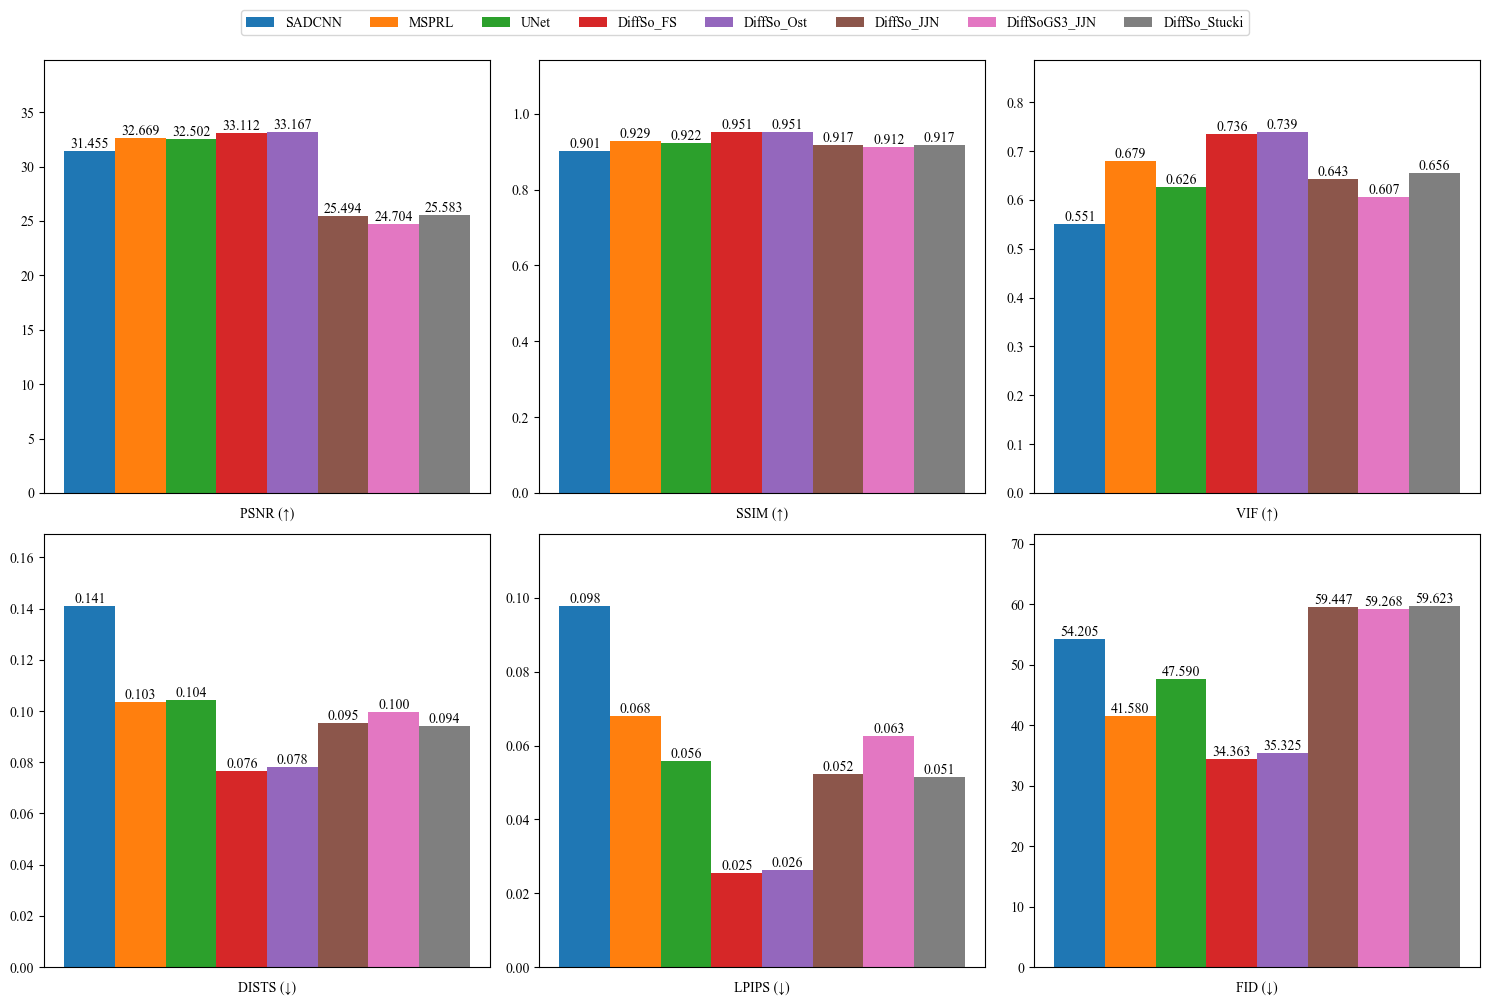

In [8]:
evaluator.visualize_metrics()